# 1. Imports

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/GNN_Simono/

In [ ]:
#%pip install torch_geometric
#%pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib qt
from tqdm.auto import tqdm
import h5py
import platform
import pickle
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
import optuna
import time
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix
import networkx as nx

import torch
from torch_geometric.data import Data, Dataset

from torch_geometric.utils import dense_to_sparse, to_networkx
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv, summary, \
  SAGEConv, GINConv, MFConv, CGConv
from torch_geometric.loader import DataLoader

from torch.optim import Adam

from gnn_utils import GNNUtils, GNNTrain_funcs
from gnn_model import GNNModel, GraphDataset

In [ ]:
def plot_label_distribution(labels, title):
    labels_temp = np.array([label.item() for label in labels])
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

# 2. Dataset creation

In [3]:
utils = GNNUtils()
train_funcs = GNNTrain_funcs()

In [ ]:
'''
        Norint tinklą apmokyti, reikia susikurti šiuos tris failus 
        pasinaudojant pymatgen_cif_parser.py. Failų pavadinimai turi 
        būti tokie patys, kaip nurodyta čia. 
'''

csv_file = 'output_core.csv'
df = pd.read_csv(csv_file)

# Load HDF5 file
hdf5_file = 'output_aux.hdf5'
hdf5_data = h5py.File(hdf5_file, 'r')

hdf5_file_species = 'output_species.hdf5'
hdf5_species = h5py.File(hdf5_file_species, 'r')

# 3. Data preprocessing

In [1]:

df['sg_bravais'] = df['sg_number'].apply(
    (lambda x: utils.map_to_bravais(sg_number=x)
    )
)

In [ ]:
df = utils.one_hot_encode_bravais(df)

In [ ]:
global_min_radius = 0
global_max_radius = 2.6 # Francium
global_min_electronegativity = 0
global_max_electronegativity = 3.98 # Fluorine

count = 0
bad_codids = []

df = utils.misc_preprocess(
    df, hdf5_file_species, global_min_radius, global_max_radius,
    global_min_electronegativity, global_max_electronegativity,
    do_unique_elements=False
    )


In [ ]:
graphs = []
count = 0

non_real_el = ['D', 'M', 'X']

print('Df shape before dropping rows: ', df.shape)
for index, row_data in tqdm(df.iterrows(), total=len(df)):

    data = utils.create_graph_object(
        row_data, index, hdf5_data, hdf5_species, non_real_el
        )
    graphs.append(data)


df.reset_index(drop=True, inplace=True)
print(f'Dropped {count} rows')
print('Df shape after dropping rows: ', df.shape)

# 4. Creating Pytorch_geometric Dataloaders

In [ ]:
'''Jeigų grafų objektai saugomi pickle faile, galima juos užkrauti'''
#with open('graphs.pkl', 'rb') as f:
#        graphs = pickle.load(f)

#with open('graphs_norm_selfloops.pkl', 'rb') as f:
#        graphs = pickle.load(f)

In [ ]:
labels = [data.y.argmax() for data in graphs]

batch_size=128

In [ ]:

train_graphs, temp_graphs, train_labels, temp_labels = train_test_split(
    graphs, labels, test_size=0.4, stratify=labels, random_state=42
)

val_graphs, test_graphs, val_labels, test_labels = train_test_split(
    temp_graphs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Plot label distribution for train, validation, and test sets
#plot_label_distribution(train_labels, 'Train Label Distribution')
#plot_label_distribution(val_labels, 'Validation Label Distribution')
#plot_label_distribution(test_labels, 'Test Label Distribution')


# Create datasets
train_dataset = GraphDataset(train_graphs, train_labels)
val_dataset = GraphDataset(val_graphs, val_labels)
test_dataset = GraphDataset(test_graphs, test_labels)

if platform.system() == 'Windows':
    num_workers = 0
else:
    num_workers = multiprocessing.cpu_count() - 2
    print(num_workers)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2,
    persistent_workers=True
    )
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=True,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2,
    persistent_workers=True
    )
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True,
    num_workers=num_workers, pin_memory=True, prefetch_factor=2
    )

10


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 5. Running hyperparameter search

In [ ]:
study = optuna.create_study(direction='minimize', study_name='GNN_study')
study.optimize(lambda trial: train_funcs.objective(trial, train_loader, val_loader), n_trials=50)
print("Best hyperparameters: ", study.best_params)

# 6. Graph neural network model parameters

In [ ]:
#GCNConv, GATConv, summary\
  #SAGEConv, GINConv, MFConv, CGConv

conv_layers = [SAGEConv, SAGEConv, MFConv]
num_layers = len(conv_layers)
#hidden_channels = [512, 1024,2048] #1024 2048
hidden_channels = [215,956,1907]
num_classes = 7
#dropout_rate = 0.6
dropout_rate = 0.6
#fc_out_channels = [1024,512,256] #1024 512 256
fc_out_channels = [2582,1324,589]
#lr = 1e-4
lr = 0.0006
#w_dec = 1e-4
w_dec = 6.8e-04
top_n = 3

model = GNNModel(
    num_classes=num_classes, dropout_rate=dropout_rate, num_layers=num_layers,
    hidden_channels=hidden_channels, conv_layer=conv_layers,
    fc_out_channels=fc_out_channels
    ).to(device)

sample_batch = next(iter(train_loader))
sample_batch.to(device)

print(summary(model, sample_batch))

optimizer = Adam(model.parameters(), lr=lr, weight_decay=w_dec)
criterion = torch.nn.CrossEntropyLoss()
epochs = 100

+------------------------------------+--------------------------+----------------+-------------+
| Layer                              | Input Shape              | Output Shape   | #Param      |
|------------------------------------+--------------------------+----------------+-------------|
| GNNModel                           | [5148, 5148]             | [128, 7]       | 124,445,793 |
| ├─(blocks)ModuleList               | --                       | --             | 124,445,793 |
| │    └─(1)ResidualBlock            | [5148, 215], [2, 65163]  | [5148, 956]    | 2,453,096   |
| │    │    └─(conv1)SAGEConv        | [5148, 215], [2, 65163]  | [5148, 956]    | 412,036     |
| │    │    └─(conv2)SAGEConv        | [5148, 956], [2, 65163]  | [5148, 956]    | 1,828,828   |
| │    │    └─(dropout)Dropout       | [5148, 956]              | [5148, 956]    | --          |
| │    │    └─(batch_norm1)GraphNorm | [5148, 956]              | [5148, 956]    | 2,868       |
| │    │    └─(batch_norm2)Gra

# 7. Run training/validation

In [ ]:
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_precisions = []
val_precisions = []
test_precisions = []
train_recalls = []
val_recalls = []
test_recalls = []
train_f1s = []
val_f1s = []
test_f1s = []

#model.load_state_dict(torch.load('Fourth_model.pth'))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
start_time = time.time()
for epoch in range(epochs):

    train_loss, train_acc, train_prec, train_rec, train_f1 = train_funcs.train_one_fold(
        train_loader, model, device, optimizer, criterion
        )
    val_loss, val_acc, val_prec, val_rec, val_f1 = train_funcs.validate_one_fold(
        val_loader, model, device, criterion
        )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    train_precisions.append(train_prec)
    val_precisions.append(val_prec)

    train_recalls.append(train_rec)
    val_recalls.append(val_rec)

    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}')
    scheduler.step()

end_time = time.time()
print(f'Training time: {end_time - start_time} seconds')

train_loss_prev = train_losses
val_loss_prev = val_losses


# 8. Plot loss/epoch graph

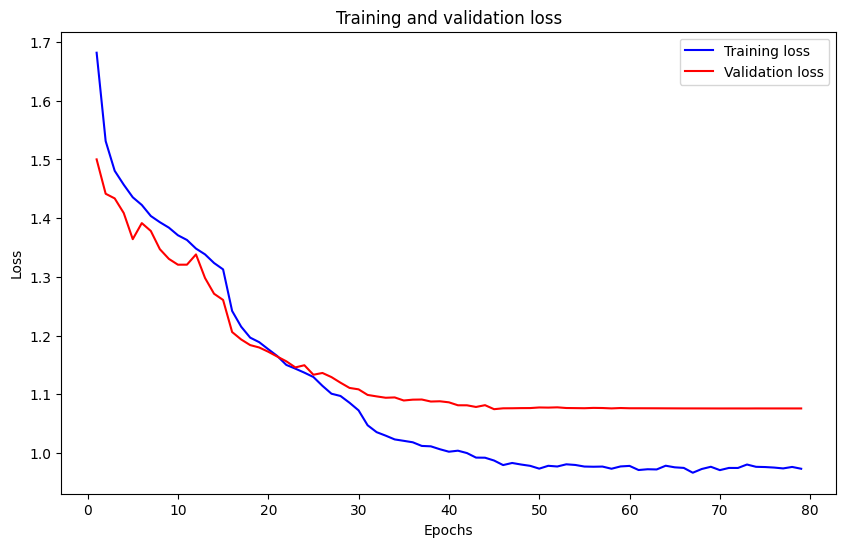

In [ ]:
name='Training_validation_loss_new_new.eps'
utils.plot_losses(train_losses, val_losses, save=False, name=name)

# 9. Testing model

  0%|          | 0/55 [00:00<?, ?it/s]

[0, 6, 6, 2, 0, 0, 5, 0, 3, 3, 4, 6, 5, 0, 0, 4, 5, 6, 2, 0, 6, 5, 1, 0, 4, 5, 1, 5, 6, 0, 4, 4, 6, 1, 1, 2, 0, 3, 5, 5, 6, 6, 6, 1, 5, 0, 6, 3, 6, 0, 4, 5, 3, 4, 6, 5, 5, 4, 4, 4, 3, 5, 4, 1, 0, 4, 3, 2, 5, 1, 5, 5, 6, 1, 1, 6, 4, 3, 1, 1, 4, 5, 0, 2, 4, 5, 5, 2, 0, 0, 5, 0, 5, 4, 1, 0, 4, 2, 5, 1, 1, 1, 1, 6, 4, 1, 3, 3, 5, 0, 3, 5, 0, 2, 6, 1, 5, 3, 3, 3, 4, 0, 5, 4, 6, 6, 6, 1, 5, 2, 4, 6, 6, 0, 0, 4, 2, 1, 3, 2, 2, 3, 3, 1, 1, 3, 2, 0, 5, 3, 5, 3, 4, 3, 0, 6, 0, 3, 0, 1, 4, 5, 2, 2, 3, 1, 0, 5, 6, 4, 3, 0, 3, 1, 1, 1, 4, 1, 5, 2, 1, 5, 2, 5, 2, 2, 5, 5, 1, 2, 6, 3, 2, 2, 3, 2, 6, 6, 0, 4, 3, 4, 2, 1, 1, 0, 3, 4, 5, 4, 5, 3, 3, 1, 5, 5, 4, 6, 6, 1, 1, 2, 3, 2, 0, 1, 0, 0, 4, 3, 2, 1, 0, 4, 0, 0, 2, 4, 3, 4, 5, 2, 0, 6, 5, 3, 3, 0, 5, 5, 4, 3, 0, 0, 6, 2, 0, 6, 4, 2, 1, 6, 0, 5, 0, 0, 2, 5, 1, 3, 5, 3, 6, 4, 5, 6, 4, 4, 6, 5, 0, 0, 5, 4, 0, 0, 0, 2, 0, 0, 1, 6, 4, 4, 1, 6, 6, 2, 2, 5, 1, 1, 1, 2, 3, 1, 6, 1, 0, 4, 3, 6, 3, 5, 4, 5, 2, 5, 0, 5, 5, 1, 6, 3, 0, 5, 3, 2, 3, 4, 6, 1, 0, 

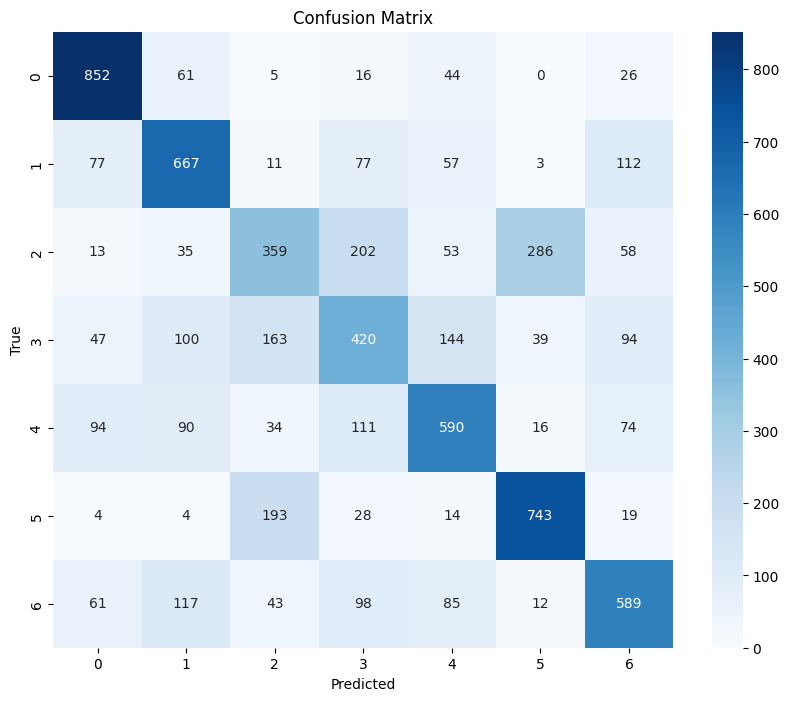

Test Loss: 1.0741,Accuracy: 0.5994, Precision: 0.5897, Recall: 0.5994, F1: 0.5930Top-N Accuracy, where N=3: 0.8855113636363636


'Testavimas su antruoju modeliu'

In [ ]:

new_model = GNNModel(
    num_classes=num_classes, dropout_rate=dropout_rate, num_layers=num_layers,
    hidden_channels=hidden_channels, conv_layer=conv_layers,
    fc_out_channels=fc_out_channels
    ).to(device)

model3 = 'Sixth_model.pth'

test_loss, all_preds, all_labels, top_n_accuracy = train_funcs.test(
    test_loader, model, device, criterion, top_n = top_n
    )


print('TEST RESULTS FOR MODEL 1')
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#plt.savefig('confusion_matrix.svg')

print(f'Test Loss: {test_loss:.4f},\
Accuracy: {accuracy:.4f}, \
Precision: {precision:.4f}, \
Recall: {recall:.4f}, \
F1: {f1:.4f}\
Top-N Accuracy, where N=3: {top_n_accuracy}')

# 10. Saving model

In [ ]:
torch.save(model.state_dict(), 'First_model.pth')

In [ ]:
from google.colab import runtime
runtime.unassign()